In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datacompy
import os, sys
import numpy as np

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy import stats
from joblib import dump, load

# modele
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# methods
from imblearn.under_sampling import ClusterCentroids, NearMiss
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

### Oversampling NEW

In [41]:
#read data
df = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\SSH.csv")
print(df.columns)
df = df.drop_duplicates()
print(df)

#label encoding
labelencoder = LabelEncoder()
#label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
column = "user"
df_encoded = labelencoder.fit_transform(df[column])
df_encoded = pd.DataFrame(df_encoded, columns=[column])
df_encoded = pd.concat([df_encoded, df.drop(columns=column)], axis=1)
df_encoded = df_encoded.drop(index=76)
df_encoded.loc[282, "user"] = 30


columns_to_convert = [col for col in df_encoded.columns if col != "ts"]
df_encoded[columns_to_convert] = df_encoded[columns_to_convert].astype(int)
print(df_encoded)
print(df_encoded.dtypes)
#standardize data
scaler = StandardScaler()
df_encoded["ts"] = scaler.fit_transform(df_encoded[["ts"]])

#split data
y = df_encoded["target"]
X = df_encoded.drop(columns=["target"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

#df_train summary X_train, y_train
df_train = pd.concat([X_train, y_train], axis=1) 
df_train['source'] = 'original' 
df_train.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\original_data.csv")

y_test.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\y_test.csv")
X_test.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\X_test.csv")

Index(['user', 'is_private', 'is_failure', 'is_root', 'is_valid',
       'not_valid_count', 'ip_failure', 'ip_success', 'no_failure', 'first',
       'td', 'ts', 'target'],
      dtype='object')
        user  is_private  is_failure  is_root  is_valid  not_valid_count  \
0     kamran           1           1        0         1                0   
1     kamran           1           1        0         1                0   
2    student           1           0        0         1                0   
3     kamran           1           1        0         1                0   
4     kamran           1           1        0         1                0   
..       ...         ...         ...      ...       ...              ...   
278   osamac           1           1        0         1                0   
279   osamac           1           1        0         1                0   
280   osamac           1           0        0         1                0   
281   osamac           1           0        0

Przed Counter({0: 151, 1: 46})
Po Counter({0: 151, 1: 151})


<Axes: xlabel='target'>

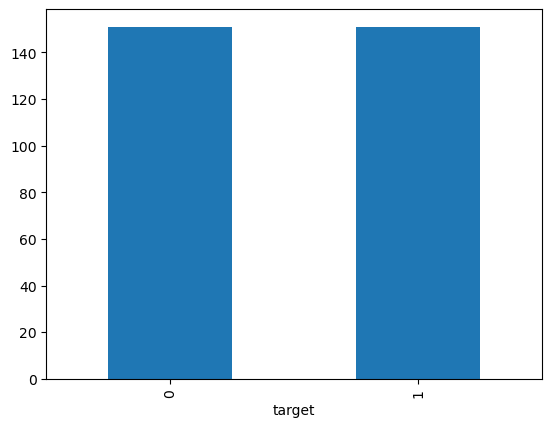

In [72]:
file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\smote_data.csv"
#zamiana jesli istnieje to wczytaj plik jesli nie to stworz
con = Counter(y_train)
print("Przed", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

train_data_smote = pd.concat([X_train_sm, y_train_sm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_smote['generated_by_smote'] = ['original' if i < len(df_train) else 'smote' for i in range(len(train_data_smote))]
smote_data = train_data_smote[train_data_smote['generated_by_smote'] == 'smote'].drop('generated_by_smote', axis=1)
smote_data["source"] = "smote"
if not os.path.exists(file_path1):
    smote_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}')
con1 = Counter(y_train_sm)
print("Po", con1)
pd.Series(y_train_sm).value_counts().plot.bar()

Przed Counter({0: 151, 1: 46})
Po Counter({0: 151, 1: 151})
(302, 12) (302,)


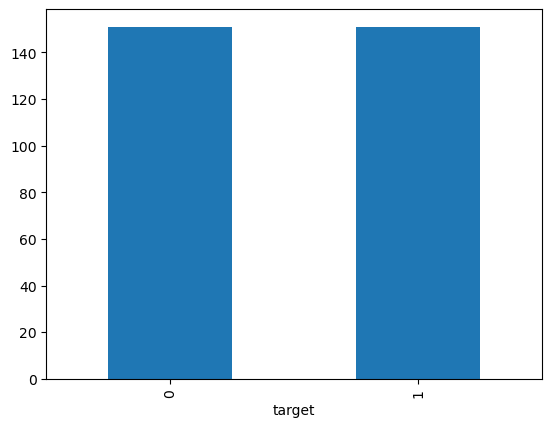

In [43]:
file_path2 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\borderline_data.csv"
#generate new data by borderLineSMOTE
con3 = Counter(y_train)
print("Przed", con3)
brdsmote = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = brdsmote.fit_resample(X_train, y_train)
con4 = Counter(y_train_bsm)
print("Po", con4)

train_data_borderline_smote = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_borderline_smote['generated_by_borderline_smote'] = ['original' if i < len(df_train) else 'brd smote' for i in range(len(train_data_borderline_smote))]
boarderline_smote_data = train_data_borderline_smote[train_data_borderline_smote['generated_by_borderline_smote'] == 'brd smote'].drop('generated_by_borderline_smote', axis=1)
boarderline_smote_data["source"]="borderline smote"
boarderline_smote_data = boarderline_smote_data[boarderline_smote_data['source'] != 'original']
if not os.path.exists(file_path2):
    boarderline_smote_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')

pd.Series(y_train_bsm).value_counts().plot.bar()
print(X_train_bsm.shape, y_train_bsm.shape)

In [ ]:
label_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

Dane wygenerowane:  target
1    105
Name: count, dtype: int64
Before Counter({0: 151, 1: 46})
After Counter({0: 151, 1: 151})
0      37
1      12
2      15
3       2
4      42
       ..
100    21
101    44
102    44
103    18
104     1
Name: user, Length: 105, dtype: int32


<Axes: xlabel='target'>

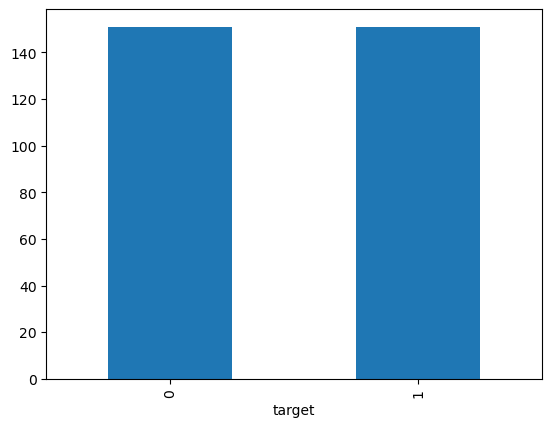

In [ ]:
file_path3 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
#generate new data by GAN

#data preparation
indexes_to_remove = y_test.index
df_gan = df.drop(index=indexes_to_remove)



columns_list = df_gan.columns
target_num = df_gan['target'].value_counts()
ctgan = CTGAN(epochs=10)        #model

if target_num[0] > target_num[1]:
    data_y1 = df_gan[df_gan['target']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['target'].value_counts())
    balanced_data = pd.concat([df_gan, df_GAN], ignore_index=False)
else:
    data_y0 = df_gan[df_gan['target']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['target'].value_counts())
    balanced_data = pd.concat([df_gan, df_GAN], ignore_index=False)



#balanced_data = balanced_data.drop(columns=["source"])  
y_train_gan = balanced_data["target"]
X_train_gan = balanced_data.drop(columns=["target"])
con5 = Counter(y_train)
print("Before", con5)
con6 = Counter(y_train_gan)
print("After", con6)
gan_data = df_GAN

#label encoding + standardize
gan_data["user"] = gan_data["user"].map(label_mapping).fillna(-1).astype(int)
column = "user"
gan_data["ts"] = scaler.fit_transform(gan_data[["ts"]])

gan_data["source"] = "gan"
if not os.path.exists(file_path3):
    gan_data.to_csv(file_path3, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path3}')

pd.Series(y_train_gan).value_counts().plot.bar()

### Data

In [133]:
#oversampling data
original_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\original_data.csv")
original_data = original_data.drop(columns=["Unnamed: 0"])
smote_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\smote_data.csv")
GAN_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\GAN_data.csv")
borderline_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\borderline_data.csv")

# test data
X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\test\\y_test.csv")

#undersampling prepare data
cc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\clustercentroids_data.csv")
if_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\isolationforest_data.csv")
nm_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\nearmiss_data.csv")
median_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\median_data.csv")
lof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\localoutlierfactor_data.csv")

In [ ]:
nm_data.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\nearmiss_data.csv")

In [ ]:
data1 = pd.concat([GAN_data, smote_data], axis=0, ignore_index=True)
data2 = pd.concat([borderline_data, original_data], axis=0, ignore_index=True)
NM_data = pd.concat([data1, data2], axis=0, ignore_index=True)
#NM_data = NM_data.drop(index=397)
#NM_data = NM_data.reset_index(drop=True) 


y_under_NM = NM_data['target']
X_under_NM = NM_data.drop(columns=["target", "source"]) 
NM = NearMiss()
X_NM, y_NM = NM.fit_resample(X_under_NM, y_under_NM)

nearmiss_data = pd.concat([X_NM, y_NM], axis=1)

#owerwrite source for nearmiss data
NM_data_nosource = NM_data.drop(columns=["source"])
nearmiss_data_nosource = nearmiss_data

for index, row in nearmiss_data_nosource.iterrows():
    match = NM_data_nosource.eq(row).all(axis=1)  # Sprawdza, gdzie wiersze są identyczne
    if match.any():  # Jeśli znaleziono dopasowanie
        matched_index = match.idxmax()  # Pobiera pierwszy pasujący indeks
        nearmiss_data.loc[index, "source"] = NM_data.loc[matched_index, "source"]
        
nearmiss_data.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\new\\nearmiss_data.csv")

In [59]:
# sum synthetic data
sum_syn_data = pd.concat([smote_data, borderline_data], axis=0)
sum_syn_data = pd.concat([sum_syn_data, GAN_data], axis=0)
sum_syn_data = sum_syn_data.reset_index(drop=True)

X_train_syn = sum_syn_data.drop(columns=["target", "source"])
y_train_syn = sum_syn_data["target"]

# sum all data
sum_data = pd.concat([original_data, sum_syn_data], axis=0)
sum_data = sum_data.reset_index(drop=True)

#sum_data.to_csv("D:\\ml\\undersampling_data\\data\\ssh\\sum_data.csv", index=False)
# X and y
X_train_sum = sum_data.drop(columns=["target", "source"])
y_train_sum = sum_data["target"]

#### Target

In [60]:
# count sum up synthetic data
syn_data = sum_syn_data.drop(columns=["source"])
num_syn = syn_data["target"].value_counts()
num_syn = int(num_syn[1])
print(f"Sum up synthetic data: {num_syn}")

# count sum up all data
num_sum = sum_data["target"].value_counts()

#calculate samples to eliminate
if num_sum[1] > 0:
    over_samples = abs(num_sum[0] - num_sum[1])
target = num_syn - over_samples
target = int(target)
print(f"Data after elimination outliers: {target}")

Sum up synthetic data: 315
Data after elimination outliers: 105


## Undersampling Data ( ClusterCentroids | IsoletionForest | Median\Dev | LocalOutlierFactor )

### ClusterCentroids - not finished
problem z przepisanie source z sum_data do cc_data

In [82]:
file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\clustercentroids_data.csv"
con = Counter(y_train_sum)
print("Before: ", con)

cluscentr = ClusterCentroids(voting="auto", sampling_strategy="majority", random_state=42)
X_train_cc, y_train_cc = cluscentr.fit_resample(X_train_sum, y_train_sum)
con = Counter(y_train_cc)
print("After: ", con)

cc_data = pd.concat([X_train_cc, y_train_cc], axis=1)
#cc_data = cc_data.reset_index(drop=True)

# Usunięcie kolumny 'source' przed porównaniem
NM_data_nosource = sum_data.drop(columns=["source"])
#nearmiss_data_nosource = cc_data

# Znalezienie pasujących wierszy i przypisanie wartości "source"
for index, row in cc_data.iterrows():
    match = NM_data_nosource.eq(row).all(axis=1)  # Sprawdza, gdzie wiersze są identyczne
    if match.any():  # Jeśli znaleziono dopasowanie
        matched_index = match.idxmax()  # Pobiera pierwszy pasujący indeks
        cc_data.loc[index, "source"] = sum_data.loc[matched_index, "source"]

if not os.path.exists(file_path1):
    cc_data.to_csv(file_path1, index=False)
else:
    print(f"Plik istnieje pod ścieżką: {file_path1}")

Before:  Counter({1: 361, 0: 151})


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


After:  Counter({0: 151, 1: 151})


### Isolation Forest

In [7]:
syn_data = sum_syn_data.drop(columns=["source"])
num_syn = syn_data["target"].value_counts()
num_syn = int(num_syn[1])
print(f"Sum up synthetic data: {num_syn}")

num_sum = sum_data["target"].value_counts()

if num_sum[1] > 0:
    over_samples = abs(num_sum[0] - num_sum[1])
target = num_syn - over_samples
target = int(target)
print(f"Data after elimination outliers: {target}")


df = syn_data.copy()
df = df.drop(columns=["target"])


def iso_forest(df, perc):
    iso_forest = IsolationForest(n_estimators=200, contamination=perc, random_state=0, n_jobs=1)
    iso_forest.fit(df)
    df["anomaly"] = iso_forest.predict(df)
    df = df[df["anomaly"] == 1].copy()
    return df


def reduce_data_if(df, target):
    current = num_syn
    while current > target:
        if (target * 2) <= current:
            perc = 0.5
            df = iso_forest(df, perc)
            current = current / 2
            print(f"Current num of samples: {current}")

        else:
            temp = current - target
            perc = 1 - (target / current)
            df = iso_forest(df, perc)
            current = current - temp
            print(f"Current num of samples: {current}")

    return df


reduced_df = reduce_data_if(df, target)
print(f"Shape after data reduced: {reduced_df.shape}")

indexes = reduced_df.index.intersection(sum_syn_data.index)
reduced_IF = sum_syn_data.loc[indexes]

file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\isolationforest_data.csv"

if_data = pd.concat([original_data, reduced_IF], axis=0)
if not os.path.exists(file_path1):
    if_data.to_csv(file_path1, index=False)

Sum up synthetic data: 315
Data after elimination outliers: 105
Current num of samples: 157.5
Current num of samples: 105.0
Shape after data reduced: (106, 13)


### Median/Dev Algorithm

In [ ]:
#learn model on sum data to get important features
model = XGBClassifier(subsample=0.5, max_depth=8, n_jobs=1)
model.fit(X_train_sum, y_train_sum)

median_before = np.median(X_train_syn, axis=0)
std_before = np.std(X_train_syn, axis=0)
print(f"Median before:\n{median_before}")
print(f"Standard deviation before:\n{std_before}")

# get 3 important features
importance = model.feature_importances_
important_features = np.argsort(importance)[-3:]
X_important = X_train_syn.iloc[:, important_features]

#calculate median and std for important features
median = np.median(X_important, axis=0)
std = np.std(X_important, axis=0)

#resampling data to get samples with values close to median
sort = np.argsort(np.sum(np.abs(X_important - median), axis=1))[:target]
X_train_med = X_train_syn.iloc[sort]
y_train_med = y_train_syn.iloc[sort]

#print(X.shape)
#print(y_train_sum.value_counts())

median_reduced = np.median(X_train_med, axis=0)
std_reduced = np.std(X_train_med, axis=0)
print(f"Median after:\n{median_reduced}")
print(f"Standard deviation after:\n{std_reduced}")

reduced_median = pd.concat([X_train_med, y_train_med], axis=1)

median_data = pd.concat([original_data, reduced_median], axis=0)

#owerwrite source for nearmiss data
nosource = sum_data.drop(columns=["source"])
data_nosource = median_data.drop(columns=["source"])

for index, row in data_nosource.iterrows():
    match = nosource.eq(row).all(axis=1)  # Sprawdza, gdzie wiersze są identyczne
    if match.any():  # Jeśli znaleziono dopasowanie
        matched_index = match.idxmax()  # Pobiera pierwszy pasujący indeks
        median_data.loc[index, "source"] = sum_data.loc[matched_index, "source"]

file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\median_data.csv"

if not os.path.exists(file_path1):
    median_data.to_csv(file_path1, index=False)
#remove 100 samples from synthetic data

Median before:
[25.          1.          1.          0.          0.          5.
 10.          0.         12.          0.         13.         -0.20966438]
Standard deviation before:
user                12.305941
is_private           0.429757
is_failure           0.000000
is_root              0.415740
is_valid             0.497249
not_valid_count      8.204080
ip_failure          13.280843
ip_success           0.740343
no_failure          11.402693
first                0.000000
td                 186.190527
ts                   1.088953
dtype: float64
Median after:
[27.          1.          1.          0.          0.          0.
  7.          0.         11.          0.         20.          0.51846515]
Standard deviation after:
user                12.241211
is_private           0.447112
is_failure           0.000000
is_root              0.368363
is_valid             0.498888
not_valid_count      6.295116
ip_failure           8.771599
ip_success           0.516046
no_failure           1.56

### LocalOutlierFactor

In [100]:
syn_data = sum_syn_data.drop(columns=["source"])
num_syn = syn_data["target"].value_counts()
num_syn = int(num_syn[1])
print(f"Sum up synthetic data: {num_syn}")

num_sum = sum_data["target"].value_counts()

if num_sum[1] > 0:
    over_samples = abs(num_sum[0] - num_sum[1])
target = num_syn - over_samples
target = int(target)
print(f"Data after elimination outliers: {target}")

df = syn_data.copy()
df = df.drop(columns=["target"])

def loc_out_fac(df, perc):
    lof = LocalOutlierFactor(n_neighbors=132, contamination=perc, metric="euclidean",novelty=True, n_jobs=1)          # <== metric="euclidean"
    lof.fit(df)
    y_lof = lof.predict(df)
    df = df[y_lof == 1].copy()
    return df

def reduce_data_lof(df, target):
    current = num_syn
    while current > target:
        if (target * 2) <= current:
            perc = 0.5
            df = loc_out_fac(df, perc)             
            current = int(current / 2)
            print(f"Current num of samples: {current}")
            print(df.shape)
            
        else:
            temp = current - target
            perc = 1 - (target / current)
            df = loc_out_fac(df, perc)
            current = int(current - temp)
            print(f"Current num of samples: {current}")
            print(df.shape)

    return df

reduced_df_lof = reduce_data_lof(df, target)
print(f"Shape after data reduced: {reduced_df_lof.shape}")

indexes = reduced_df_lof.index.intersection(sum_syn_data.index)
reduced_lof = sum_syn_data.loc[indexes]

file_path1 = "D:\\ml\\undersampling_data\\data\\ssh\\new\\localoutlierfactor_data.csv"

lof_data = pd.concat([original_data, reduced_lof], axis=0)
#lof_data = lof_data.drop(columns=["Unnamed: 0"])
if not os.path.exists(file_path1):
    lof_data.to_csv(file_path1, index=False)

Sum up synthetic data: 315
Data after elimination outliers: 105
Current num of samples: 157
(159, 12)
Current num of samples: 105
(117, 12)
Shape after data reduced: (117, 12)


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


## Learning Models

### Dictionary

In [ ]:
# models to learn
models = {}

models["LR"] = LogisticRegression(max_iter=500, random_state=0)
models["LR_NM"] = LogisticRegression(max_iter=100, random_state=0)
models["LR_IF"] = LogisticRegression(max_iter=1000, random_state=0)
models["LR_MD"] = LogisticRegression(max_iter=1000, random_state=0)
models["LR_LOF"] = LogisticRegression(max_iter=1000, random_state=0)
models["LR_CC"] = LogisticRegression(max_iter=500, random_state=0)  

models["DT"] = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=0)
models["DT_NM"] = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=0)
models["DT_IF"] = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=0)   
models["DT_MD"] = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=20)
models["DT_LOF"] = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=0)
models["DT_CC"] = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=0)

models["RF"] = RandomForestClassifier(max_depth=12, min_samples_leaf=1, n_estimators=40, random_state=0)
models["RF_NM"] = RandomForestClassifier(max_depth=12, min_samples_leaf=1, n_estimators=20, random_state=30)
models["RF_IF"] = RandomForestClassifier(max_depth=8, min_samples_leaf=1, n_estimators=60, random_state=40)
models["RF_MD"] = RandomForestClassifier(max_depth=8, min_samples_leaf=1, n_estimators=20, random_state=10) 
models["RF_LOF"] = RandomForestClassifier(max_depth=8, min_samples_leaf=1, n_estimators=20, random_state=30)
models["RF_CC"] = RandomForestClassifier(max_depth=8, min_samples_leaf=1, n_estimators=20, random_state=10)

models["XGB"] = XGBClassifier(max_depth=4, subsample=1)
models["XGB_NM"] = XGBClassifier(max_depth=4, subsample=0.5)
models["XGB_IF"] = XGBClassifier(max_depth=4, subsample=1)
models["XGB_MD"] = XGBClassifier(max_depth=4, subsample=1)
models["XGB_LOF"] = XGBClassifier(max_depth=4, subsample=0.6)
models["XGB_CC"] = XGBClassifier(max_depth=4, subsample=0.5)

models["XGBRF"] = XGBRFClassifier(max_depth=4, subsample=0.5)
models["XGBRF_NM"] = XGBRFClassifier(max_depth=4, subsample=0.5)
models["XGBRF_IF"] = XGBRFClassifier(max_depth=4, subsample=0.5)
models["XGBRF_MD"] = XGBRFClassifier(max_depth=4, subsample=0.5)
models["XGBRF_LOF"] = XGBRFClassifier(max_depth=4, subsample=0.5)
models["XGBRF_CC"] = XGBRFClassifier(max_depth=4, subsample=0.5)

In [111]:
# data to learn
training_data = {}   

training_data["LR"] = (X_train_sum, y_train_sum)
training_data["LR_NM"] = (nm_data.drop(columns=["target", "source"]), nm_data["target"])
training_data["LR_IF"] = (if_data.drop(columns=["target", "source"]), if_data["target"])
training_data["LR_MD"] = (median_data.drop(columns=["target", "source"]), median_data["target"])
training_data["LR_LOF"] = (lof_data.drop(columns=["target", "source"]), lof_data["target"])
training_data["LR_CC"] = (cc_data.drop(columns=["target", "source"]), cc_data["target"])

training_data["DT"] = (X_train_sum, y_train_sum)
training_data["DT_NM"] = (nm_data.drop(columns=["target", "source"]), nm_data["target"])
training_data["DT_IF"] = (if_data.drop(columns=["target", "source"]), if_data["target"])
training_data["DT_MD"] = (median_data.drop(columns=["target", "source"]), median_data["target"])
training_data["DT_LOF"] = (lof_data.drop(columns=["target", "source"]), lof_data["target"])
training_data["DT_CC"] = (cc_data.drop(columns=["target", "source"]), cc_data["target"])

training_data["RF"] = (X_train_sum, y_train_sum)
training_data["RF_NM"] = (nm_data.drop(columns=["target", "source"]), nm_data["target"])
training_data["RF_IF"] = (if_data.drop(columns=["target", "source"]), if_data["target"])
training_data["RF_MD"] = (median_data.drop(columns=["target", "source"]), median_data["target"])
training_data["RF_LOF"] = (lof_data.drop(columns=["target", "source"]), lof_data["target"])
training_data["RF_CC"] = (cc_data.drop(columns=["target", "source"]), cc_data["target"])

training_data["XGB"] = (X_train_sum, y_train_sum)
training_data["XGB_NM"] = (nm_data.drop(columns=["target", "source"]), nm_data["target"])
training_data["XGB_IF"] = (if_data.drop(columns=["target", "source"]), if_data["target"])
training_data["XGB_MD"] = (median_data.drop(columns=["target", "source"]), median_data["target"])
training_data["XGB_LOF"] = (lof_data.drop(columns=["target", "source"]), lof_data["target"])
training_data["XGB_CC"] = (cc_data.drop(columns=["target", "source"]), cc_data["target"])

training_data["XGBRF"] = (X_train_sum, y_train_sum)
training_data["XGBRF_NM"] = (nm_data.drop(columns=["target", "source"]), nm_data["target"])
training_data["XGBRF_IF"] = (if_data.drop(columns=["target", "source"]), if_data["target"])
training_data["XGBRF_MD"] = (median_data.drop(columns=["target", "source"]), median_data["target"])
training_data["XGBRF_LOF"] = (lof_data.drop(columns=["target", "source"]), lof_data["target"])
training_data["XGBRF_CC"] = (cc_data.drop(columns=["target", "source"]), cc_data["target"])

In [152]:
print(nm_data)
print(if_data)
print(median_data)
print(lof_data)
print(cc_data)


     Unnamed: 0  user  is_private  is_failure  is_root  is_valid  \
0             0    37           1           0        0         1   
1             1    40           1           0        0         1   
2             2    24           1           1        0         1   
3             3    40           1           1        0         1   
4             4    36           1           1        0         0   
..          ...   ...         ...         ...      ...       ...   
297         297    10           1           1        0         0   
298         298    32           1           1        0         0   
299         299    27           1           1        0         1   
300         300    18           1           1        0         0   
301         301    35           0           1        1         1   

     not_valid_count  ip_failure  ip_success  no_failure  first    td  \
0                  0           0          14           0      0  6697   
1                  0           0     

### Grid-Search

In [108]:
# parameters for models
params_ = {}

params_["LR"] = {
    'max_iter':[100,500,1000]  ,
    'random_state':[0,10,20,30,40]
}

params_["DT"] = {                           
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
    'min_samples_leaf':[1,2]                # minimalna ilosc probek lisci
}

params_["RF"] = {
    'n_estimators':[20,40,60,80,100],       # rozmiar lasu
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'min_samples_leaf':[1,2],               # minimalna ilosc probek lisci
    'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
}

params_["XGB"] = {                              
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'subsample':[0.5,0.6,0.7,0.8,0.9,1]
}

params_["XGBRF"] = {                           
    'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
    'n_estimators':[20,40,60,80,100],       # rozmiar lasu
    'subsample':[0.5,0.6,0.7,0.8,0.9,1],
    'random_state':[0,10,20,30,40]          # ustalona losowość dla powtarzalności
}

goal = ['accuracy','precision', 'recall', 'f1'] 
file_pathes = ["D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\accuracy.txt"
                ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\precision.txt"
               ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\recall.txt"
               ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\f1.txt"]

for score_1, file_path in zip(goal, file_pathes):
    for model_key, data_key in zip(models.keys(), training_data.keys()):
        model = models[model_key]
        data = training_data[data_key]
        
        param_grid = None
        for key in params_.keys():
            if model_key.startswith(key):
                param_grid = params_[key]
                break
        
        if param_grid is not None:
            grid_search = GridSearchCV(model, param_grid=param_grid, scoring=score_1, n_jobs=1).fit(data[0], data[1])
            print(f"{score_1} & {model_key}")
            with open(file_path, "a+") as f:
                print(f'scoring: {score_1}', file=f)
                print(f'Best parameters for {score_1} & {model_key}:', grid_search.best_params_, file=f)
                print(f'Best score for {score_1} & {model_key}:', grid_search.best_score_, file=f)
"""     model_LR = LogisticRegression()
    model_LR_SMOTE = LogisticRegression()
    model_LR_BrdSMOTE = LogisticRegression()
    model_LR_GAN = LogisticRegression()
    model_DT = DecisionTreeClassifier()
    model_DT_SMOTE = DecisionTreeClassifier()
    model_DT_BrdSMOTE = DecisionTreeClassifier()
    model_DT_GAN = DecisionTreeClassifier()
    model_RF = RandomForestClassifier()
    model_RF_SMOTE = RandomForestClassifier()
    model_RF_BrdSMOTE = RandomForestClassifier()
    model_RF_GAN = RandomForestClassifier()
    model_XGB = XGBClassifier()
    model_XGB_SMOTE = XGBClassifier()
    model_XGB_BrdSMOTE = XGBClassifier()
    model_XGB_GAN = XGBClassifier()
    model_XGB_RF = XGBRFClassifier()
    model_XGB_RF_SMOTE = XGBRFClassifier()
    model_XGB_RF_BrdSMOTE = XGBRFClassifier()
    model_XGB_RF_GAN = XGBRFClassifier()
    
    model_LR_GAN = GridSearchCV(model_LR_GAN,param_grid=params_LR,scoring=score_1).fit(X_train_gan,y_train_gan)
    model_DT_GAN = GridSearchCV(model_DT_GAN,param_grid=params_DT,scoring=score_1).fit(X_train_gan,y_train_gan)
    model_RF_GAN = GridSearchCV(model_RF_GAN,param_grid=params_RF,scoring=score_1).fit(X_train_gan,y_train_gan)
    model_XGB_GAN = GridSearchCV(model_XGB_GAN,param_grid=params_XGB, scoring=score_1).fit(X_train_gan,y_train_gan)
    model_XGB_RF_GAN = GridSearchCV(model_XGB_RF_GAN,param_grid=params_XGB_RF,scoring=score_1).fit(X_train_gan,y_train_gan)
    
    with open(file_path, "a+") as f:
        print(f'scoring: {score_1}', file=f)
        print(f'Best parameters for {score_1} & LR + {call}:', model_LR_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & LR + {call}:', model_LR_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & DT + {call}:', model_DT_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & DT + {call}:', model_DT_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & RF + {call}:', model_RF_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & RF + {call}:', model_RF_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & XGB + {call}:', model_XGB_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & XGB + {call}:', model_XGB_GAN.best_score_, file=f)
        print(f'Best parameters for {score_1} & XGB RF + {call}:', model_XGB_RF_GAN.best_params_, file=f)
        print(f'Best score for {score_1} & XGB RF + {call}:', model_XGB_RF_GAN.best_score_, file=f)
 """

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_IF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_MD


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_LOF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

accuracy & LR_CC
accuracy & DT
accuracy & DT_NM
accuracy & DT_IF
accuracy & DT_MD
accuracy & DT_LOF
accuracy & DT_CC
accuracy & RF
accuracy & RF_NM
accuracy & RF_IF
accuracy & RF_MD
accuracy & RF_LOF
accuracy & RF_CC
accuracy & XGB
accuracy & XGB_NM
accuracy & XGB_IF
accuracy & XGB_MD
accuracy & XGB_LOF
accuracy & XGB_CC
accuracy & XGBRF
accuracy & XGBRF_NM
accuracy & XGBRF_IF
accuracy & XGBRF_MD
accuracy & XGBRF_LOF
accuracy & XGBRF_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_IF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_MD


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_LOF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

precision & LR_CC
precision & DT
precision & DT_NM
precision & DT_IF
precision & DT_MD
precision & DT_LOF
precision & DT_CC
precision & RF
precision & RF_NM
precision & RF_IF
precision & RF_MD
precision & RF_LOF
precision & RF_CC
precision & XGB
precision & XGB_NM
precision & XGB_IF
precision & XGB_MD
precision & XGB_LOF
precision & XGB_CC
precision & XGBRF
precision & XGBRF_NM
precision & XGBRF_IF
precision & XGBRF_MD
precision & XGBRF_LOF
precision & XGBRF_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_IF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_MD


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_LOF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

recall & LR_CC
recall & DT
recall & DT_NM
recall & DT_IF
recall & DT_MD
recall & DT_LOF
recall & DT_CC
recall & RF
recall & RF_NM
recall & RF_IF
recall & RF_MD
recall & RF_LOF
recall & RF_CC
recall & XGB
recall & XGB_NM
recall & XGB_IF
recall & XGB_MD
recall & XGB_LOF
recall & XGB_CC
recall & XGBRF
recall & XGBRF_NM
recall & XGBRF_IF
recall & XGBRF_MD
recall & XGBRF_LOF
recall & XGBRF_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_IF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_MD


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_LOF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

f1 & LR_CC
f1 & DT
f1 & DT_NM
f1 & DT_IF
f1 & DT_MD
f1 & DT_LOF
f1 & DT_CC
f1 & RF
f1 & RF_NM
f1 & RF_IF
f1 & RF_MD
f1 & RF_LOF
f1 & RF_CC
f1 & XGB
f1 & XGB_NM
f1 & XGB_IF
f1 & XGB_MD
f1 & XGB_LOF
f1 & XGB_CC
f1 & XGBRF
f1 & XGBRF_NM
f1 & XGBRF_IF
f1 & XGBRF_MD
f1 & XGBRF_LOF
f1 & XGBRF_CC


'     model_LR = LogisticRegression()\n    model_LR_SMOTE = LogisticRegression()\n    model_LR_BrdSMOTE = LogisticRegression()\n    model_LR_GAN = LogisticRegression()\n    model_DT = DecisionTreeClassifier()\n    model_DT_SMOTE = DecisionTreeClassifier()\n    model_DT_BrdSMOTE = DecisionTreeClassifier()\n    model_DT_GAN = DecisionTreeClassifier()\n    model_RF = RandomForestClassifier()\n    model_RF_SMOTE = RandomForestClassifier()\n    model_RF_BrdSMOTE = RandomForestClassifier()\n    model_RF_GAN = RandomForestClassifier()\n    model_XGB = XGBClassifier()\n    model_XGB_SMOTE = XGBClassifier()\n    model_XGB_BrdSMOTE = XGBClassifier()\n    model_XGB_GAN = XGBClassifier()\n    model_XGB_RF = XGBRFClassifier()\n    model_XGB_RF_SMOTE = XGBRFClassifier()\n    model_XGB_RF_BrdSMOTE = XGBRFClassifier()\n    model_XGB_RF_GAN = XGBRFClassifier()\n    \n    model_LR_GAN = GridSearchCV(model_LR_GAN,param_grid=params_LR,scoring=score_1).fit(X_train_gan,y_train_gan)\n    model_DT_GAN = GridS

### Learn models ( 10-cross validation)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
results_cross_mean_under=[]
results_cross_std_under=[]
goal = ['accuracy', 'precision','f1','recall']
path_files = ["D:\\ml\\undersampling_data\\reports\\ssh\\results\\accuracy_metrics.txt",
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\precision_metrics.txt", 
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\f1_metrics.txt", 
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\recall_metrics.txt"]

excel_file_cross = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\cross.xlsx"
excel_file_cross2 = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\cross_std.xlsx"
name_sheet1 = "Arkusz1"

model_scores = {}

for metrix1, path_file in zip(goal, path_files):
    for model_key, data_key in zip(models.keys(), training_data.keys()):
        model = models[model_key]
        X_train, y_train = training_data[model_key]
        cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=metrix1, n_jobs=1)
        print(f"Learn: {metrix1} and model {model_key}")
        with open(path_file, "a+") as f:
            # Zapis wyników do pliku
            print(f'{model_key} Cross-Validation Results {metrix1}:\n {cross_val_results}', file=f)
            print(f'Mean {metrix1}: {cross_val_results.mean()}', file=f)
            print(f'Dev: {cross_val_results.std()}', file=f)
            print("\n", file=f)
        
        results_cross_mean_under.append({
        "Model": model_key,
        "Metric": metrix1,
        "Result": cross_val_results.mean()})
        results_cross_std_under.append({
        "Model": model_key,
        "Metric": metrix1,
        "Std": cross_val_results.std()})
        df_results_cross_under_mean = pd.DataFrame(results_cross_mean_under)
        df_results_cross_under_std = pd.DataFrame(results_cross_std_under)
        df_save_under_mean = df_results_cross_under_mean.pivot(index="Metric", columns="Model", values="Result")
        df_save_under_std = df_results_cross_under_std.pivot(index="Metric", columns="Model", values="Std")
        
        with pd.ExcelFile(excel_file_cross) as w:
            df_save_under_mean.to_excel(w, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file_cross2) as w1:
            df_save_under_std.to_excel(w1, sheet_name=name_sheet1)


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_IF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_MD


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_LOF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: accuracy and model LR_CC
Learn: accuracy and model DT
Learn: accuracy and model DT_NM
Learn: accuracy and model DT_IF
Learn: accuracy and model DT_MD
Learn: accuracy and model DT_LOF
Learn: accuracy and model DT_CC
Learn: accuracy and model RF
Learn: accuracy and model RF_NM
Learn: accuracy and model RF_IF
Learn: accuracy and model RF_MD
Learn: accuracy and model RF_LOF
Learn: accuracy and model RF_CC
Learn: accuracy and model XGB
Learn: accuracy and model XGB_NM
Learn: accuracy and model XGB_IF
Learn: accuracy and model XGB_MD
Learn: accuracy and model XGB_LOF
Learn: accuracy and model XGB_CC
Learn: accuracy and model XGBRF
Learn: accuracy and model XGBRF_NM
Learn: accuracy and model XGBRF_IF
Learn: accuracy and model XGBRF_MD
Learn: accuracy and model XGBRF_LOF
Learn: accuracy and model XGBRF_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_IF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_MD


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_LOF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: precision and model LR_CC
Learn: precision and model DT
Learn: precision and model DT_NM
Learn: precision and model DT_IF
Learn: precision and model DT_MD
Learn: precision and model DT_LOF
Learn: precision and model DT_CC
Learn: precision and model RF
Learn: precision and model RF_NM
Learn: precision and model RF_IF
Learn: precision and model RF_MD
Learn: precision and model RF_LOF
Learn: precision and model RF_CC
Learn: precision and model XGB
Learn: precision and model XGB_NM
Learn: precision and model XGB_IF
Learn: precision and model XGB_MD
Learn: precision and model XGB_LOF
Learn: precision and model XGB_CC
Learn: precision and model XGBRF
Learn: precision and model XGBRF_NM
Learn: precision and model XGBRF_IF
Learn: precision and model XGBRF_MD
Learn: precision and model XGBRF_LOF
Learn: precision and model XGBRF_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_IF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_MD


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_LOF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: f1 and model LR_CC
Learn: f1 and model DT
Learn: f1 and model DT_NM
Learn: f1 and model DT_IF
Learn: f1 and model DT_MD
Learn: f1 and model DT_LOF
Learn: f1 and model DT_CC
Learn: f1 and model RF
Learn: f1 and model RF_NM
Learn: f1 and model RF_IF
Learn: f1 and model RF_MD
Learn: f1 and model RF_LOF
Learn: f1 and model RF_CC
Learn: f1 and model XGB
Learn: f1 and model XGB_NM
Learn: f1 and model XGB_IF
Learn: f1 and model XGB_MD
Learn: f1 and model XGB_LOF
Learn: f1 and model XGB_CC
Learn: f1 and model XGBRF
Learn: f1 and model XGBRF_NM
Learn: f1 and model XGBRF_IF
Learn: f1 and model XGBRF_MD
Learn: f1 and model XGBRF_LOF
Learn: f1 and model XGBRF_CC


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_NM


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_IF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_MD


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_LOF


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Learn: recall and model LR_CC
Learn: recall and model DT
Learn: recall and model DT_NM
Learn: recall and model DT_IF
Learn: recall and model DT_MD
Learn: recall and model DT_LOF
Learn: recall and model DT_CC
Learn: recall and model RF
Learn: recall and model RF_NM
Learn: recall and model RF_IF
Learn: recall and model RF_MD
Learn: recall and model RF_LOF
Learn: recall and model RF_CC
Learn: recall and model XGB
Learn: recall and model XGB_NM
Learn: recall and model XGB_IF
Learn: recall and model XGB_MD
Learn: recall and model XGB_LOF
Learn: recall and model XGB_CC
Learn: recall and model XGBRF
Learn: recall and model XGBRF_NM
Learn: recall and model XGBRF_IF
Learn: recall and model XGBRF_MD
Learn: recall and model XGBRF_LOF
Learn: recall and model XGBRF_CC


In [118]:
for model_name, model in models.items():  
    name = f"D:\\ml\\undersampling_data\\models\\ssh\\{model_name}.joblib"  
    dump(model, name)
    print(f"Model {model_name} saved in: {name}")

Model LR saved in: D:\ml\undersampling_data\models\ssh\LR.joblib
Model LR_NM saved in: D:\ml\undersampling_data\models\ssh\LR_NM.joblib
Model LR_IF saved in: D:\ml\undersampling_data\models\ssh\LR_IF.joblib
Model LR_MD saved in: D:\ml\undersampling_data\models\ssh\LR_MD.joblib
Model LR_LOF saved in: D:\ml\undersampling_data\models\ssh\LR_LOF.joblib
Model LR_CC saved in: D:\ml\undersampling_data\models\ssh\LR_CC.joblib
Model DT saved in: D:\ml\undersampling_data\models\ssh\DT.joblib
Model DT_NM saved in: D:\ml\undersampling_data\models\ssh\DT_NM.joblib
Model DT_IF saved in: D:\ml\undersampling_data\models\ssh\DT_IF.joblib
Model DT_MD saved in: D:\ml\undersampling_data\models\ssh\DT_MD.joblib
Model DT_LOF saved in: D:\ml\undersampling_data\models\ssh\DT_LOF.joblib
Model DT_CC saved in: D:\ml\undersampling_data\models\ssh\DT_CC.joblib
Model RF saved in: D:\ml\undersampling_data\models\ssh\RF.joblib
Model RF_NM saved in: D:\ml\undersampling_data\models\ssh\RF_NM.joblib
Model RF_IF saved in

In [146]:
#X_test = X_test.drop(columns=["Unnamed: 0"])
#y_test = y_test.drop(columns=["Unnamed: 0"])

In [147]:
for model_key, data_key in zip(models.keys(), training_data.keys()):
    X_train, y_train = training_data[data_key]
        # Load the best model using pickle
    model_filename = f"D:\\ml\\undersampling_data\\models\\ssh\\{model_key}.joblib"
    with open(model_filename, 'rb') as model_file:
        best_model = load(model_file)
        
        best_model.fit(X_train, y_train)
        # Predict using the best model
        y_pred = best_model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for {model_key}")
        print(cm)

        cr = classification_report(y_test, y_pred)
        print(f"Classification Report for {model_key}")
        print(cr)

Confusion Matrix for LR
[[63  2]
 [ 1 19]]
Classification Report for LR
              precision    recall  f1-score   support

           0       0.98      0.97      0.98        65
           1       0.90      0.95      0.93        20

    accuracy                           0.96        85
   macro avg       0.94      0.96      0.95        85
weighted avg       0.97      0.96      0.96        85



c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Unnamed: 0


In [ ]:
for model_key, model in models.items():
    
    # Pobieramy odpowiednie dane do trenowania dla bieżącego modelu
    X_train, y_train = training_data[model_key]
    learned = model.fit(X_train, y_train)      
    y_pred = learned.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
            
    sns.heatmap(conf_mat, annot=True, xticklabels=["1", "0"], yticklabels=["1", "0"])
    plt.ylabel("Test", fontsize=13)
    plt.title(f"Confusion Matrix: {model_name}", fontsize=15, pad=20)
    plt.gca().xaxis.set_label_position("top")
    plt.xlabel("Symulacja", fontsize=13)
    plt.gca().xaxis.tick_top()
    plt.savefig(f'D:\\ml\\xgboost-main\\reports\\ssh\\conf matrix\\{model_name}.png', bbox_inches="tight", dpi=200)     
    plt.show()
    plt.close()  